# Séance 3 - Compléments

Dans cette séance nous travaillerons avec le dataset d'image CIFAR10. Il correspond à des petites images en couleurs. Notre objectif est de construire un réseau de neurones convolutionnel capable d'identifier chacun des dix types.

Commençons par importer quelques librairies qui nous serons utile pour la suite:
* **Numpy** : Calcul matriciel
* **Pandas** : Travail avec des DataFrame
* **Matplotlib** : Graphiques, et on utilise également la sur-couche **seaborn**
* **Tensorflow** : librairie qui permet la définition de réseau de neurones, et une *interface* plus simple d'utilisation **Keras**

Nous allons également importer les données, et modifier un peu les *y* pour pouvoir utiliser la *data augmentation*.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
cifar10 = keras.datasets.cifar10
(X_train, y_train), (X_valid, y_valid) = (cifar10.load_data())
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)

label_map = {0: "airplane", 1: "automobile", 2: "bird",
             3: "cat", 4: "deer", 5: "dog",
             6: "frog", 7: "horse", 8: "ship", 9: "truck  "}

Visualisons quelques images pour se familiariser avec le dataset:

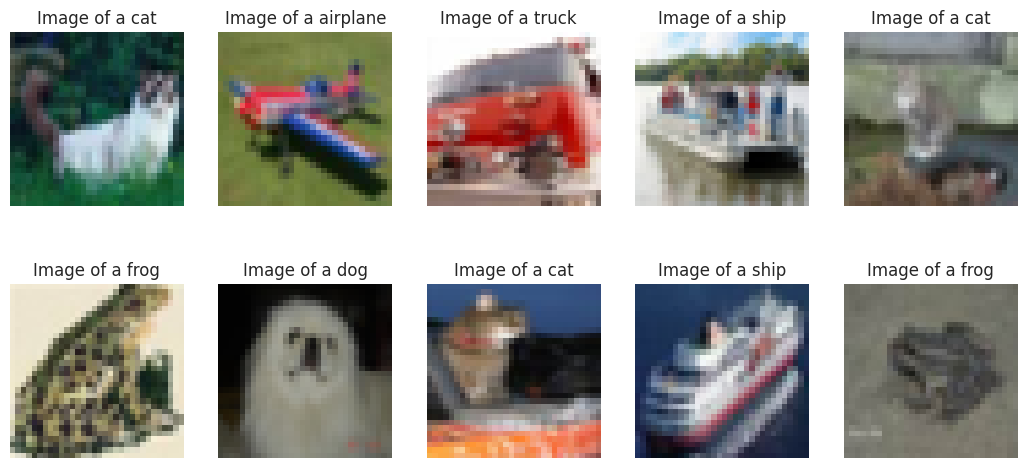

In [2]:
n = 10

plt.figure(figsize=(13, 6))
for plot_index in range(1, n+1):
  plt.subplot(2, 5, plot_index)
  index = np.random.randint(low=0, high=len(X_train))
  plt.imshow(X_train[index])
  plt.title("Image of a %s" % label_map[np.argmax(y_train[index])])
  plt.axis('off')
plt.show()

Nous allons à présent standardiser les données, en faisant attention de bien respecter les dimensions des images.
Cette fois nous avons décidé de ne pas générer de dataset de test, et de seulement exploiter *train* et *validation*.

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 32 * 32 * 3)).reshape(-1, 32, 32, 3)


for (dataset, name) in zip([X_train, X_valid], ["Train", "Validation"]):
  print(name, ":", dataset.shape)

Nous avons 50000 images différentes dans le train, et nous allons exploiter la *data augmentation* pour en réalité en avoir un peu plus.

Cela consiste à définir un générateur d'images qui s'appuie sur le *train* et qui va de manière aléatoire appliquer des modifications à l'image. Ici nous choisissons d'avoir:
* *rotation_range* : applique une rotation d'un angle de valeur au plus celle renseigné par l'utilisateur
* *width_shift_range* : décale aléatoirement l'image horizontalement d'une fraction de l'image
* *height_shift_range* : décale aléatoirement l'image verticalement d'une fraction de l'image
* *horizontal_flip* : retourne horizontalement l'image

In [4]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

Cela devrait nous permettre d'avoir une meilleure généralisation. Définissons un modèle:

In [5]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="valid", activation="relu", kernel_initializer="he_normal", input_shape=[32, 32, 3]),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_initializer="he_normal"),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")
])
model.summary()

Il ne nous reste plus qu'à lancer l'apprentissage ! Nous avons décidé de travailler avec un générateur d'image, donc nous allons l'exploiter dans l'appel *.fit* du modèle.

Puisque nous avons modifié les *y*, nous devons modifier la loss que l'on exploite. En réalité, il s'agit de la même, mais avec un format différent pour s'adapter à la modification des *y*.

In [7]:
batch_size = 32
n_epochs = 5
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=0.001), metrics=["accuracy"])
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch = X_train.shape[0] // batch_size, epochs=n_epochs, validation_data=(X_valid, y_valid))

Epoch 1/5
1562/1562 [==============================] - 417s 263ms/step - loss: 1.4985 - accuracy: 0.4571 - val_loss: 1.1464 - val_accuracy: 0.5923
Epoch 2/5
1562/1562 [==============================] - 362s 232ms/step - loss: 1.0858 - accuracy: 0.6187 - val_loss: 0.9243 - val_accuracy: 0.6759
Epoch 3/5
1562/1562 [==============================] - 324s 208ms/step - loss: 0.9385 - accuracy: 0.6737 - val_loss: 0.8941 - val_accuracy: 0.6931
Epoch 4/5
1562/1562 [==============================] - 325s 208ms/step - loss: 0.8590 - accuracy: 0.7019 - val_loss: 0.8456 - val_accuracy: 0.7106
Epoch 5/5
1562/1562 [==============================] - 326s 209ms/step - loss: 0.7984 - accuracy: 0.7235 - val_loss: 0.8103 - val_accuracy: 0.7248


## A vous de jouer !